# Start Here: A Gentle Introduction
This Notebook is based on the following notebook: https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction from a Kaggle Competition.


## Setup
Download the application_train from here: https://www.kaggle.com/c/home-credit-default-risk/data and run the following.
The reason we need to do this is because the "Home Credit Default Risk" competition does not provide labels for their test data and the only way of getting the score is to send the submission file.
To avoid that, we split the training data into train/test so we can compute the ROC curve without submission.

In [1]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split

app_train = pd.read_csv('./data/application_train.csv')
train, test = train_test_split(app_train, test_size=0.2)
test_labels = test[['SK_ID_CURR', 'TARGET']]
test = test.drop(columns='TARGET', inplace=False)

if not os.path.exists('./data/final'):
    os.mkdir('./data/final')

train.to_csv('./data/final/application_train.csv', index=False)
test.to_csv('./data/final/application_test.csv', index=False)

test_labels.to_csv('./data/final/application_test_labels.csv', index=False)

In [2]:
# Environment Import
from experiment_graph.execution_environment import ExecutionEnvironment
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

/Users/bede01/Documents/work/phd-papers/published/ml-workload-optimization/code/collaborative-optimizer/experiment_graph/graph/node.py:48: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if k is 'execution_environment':


In [3]:
execution_environment = ExecutionEnvironment()
root_data = './data/final'

## Load Input Data

['application_test_labels.csv', 'application_test.csv', 'application_train.csv']
creating a new root node
Training data shape:  (246008, 122)
creating a new root node
Testing data shape:  (61503, 121)
creating a new root node


<AxesSubplot:ylabel='Frequency'>

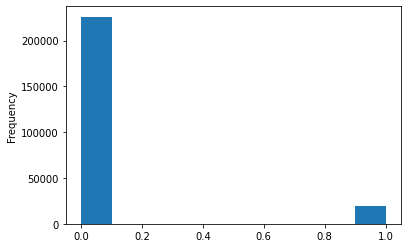

In [4]:
print(os.listdir(root_data))
app_train = execution_environment.load(root_data + '/application_train.csv')
print('Training data shape: ', app_train.shape().data())
app_train.head().data()

app_test = execution_environment.load(root_data + '/application_test.csv')
print('Testing data shape: ', app_test.shape().data())
app_test.head().data()

test_labels = execution_environment.load(root_data + '/application_test_labels.csv')

app_train['TARGET'].value_counts().data()

app_train['TARGET'].data().astype(int).plot.hist()

## Examine Missing Values

In [5]:
# Function to calculate missing values by column# Funct
def missing_values_table(dataset):
    # Total missing values
    mis_val = dataset.isnull().sum().data()

    mis_val_percent = 100 * mis_val / len(dataset.data())

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(columns={
        0: 'Missing Values',
        1: '% of Total Values'
    })
    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

    # Print some summary information
    print("Your selected dataframe has " + str(dataset.shape().data()[1]) + " columns.\n"
                                                                                   "There are " + str(
        mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

missing_values = missing_values_table(app_train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,172008,69.9
COMMONAREA_AVG,172008,69.9
COMMONAREA_MODE,172008,69.9
NONLIVINGAPARTMENTS_MEDI,170881,69.5
NONLIVINGAPARTMENTS_MODE,170881,69.5
NONLIVINGAPARTMENTS_AVG,170881,69.5
FONDKAPREMONT_MODE,168341,68.4
LIVINGAPARTMENTS_MODE,168213,68.4
LIVINGAPARTMENTS_MEDI,168213,68.4
LIVINGAPARTMENTS_AVG,168213,68.4


In [6]:
app_train.dtypes().data().value_counts()
app_train.select_dtypes('object').nunique().data()

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

## Encoding Categorical Variables

In [7]:
from experiment_graph.sklearn_helper.preprocessing import LabelEncoder
# Create a label encoder object
le_count = 0

columns = app_train.select_dtypes('object').data().columns
for col in columns:
    # we are not using nunique because it discard nan
    if app_train[col].nunique(dropna=False).data() <= 2:
        le = LabelEncoder()
        le.fit(app_train[col])

        app_train = app_train.replace_columns(col, le.transform(app_train[col]))
        app_test = app_test.replace_columns(col, le.transform(app_test[col]))

        # Keep track of how many columns were label encoded
        le_count += 1
print('%d columns were label encoded.' % le_count)
app_train.data()
app_test.data()

app_train = app_train.onehot_encode()
app_test = app_test.onehot_encode()

print('Training Features shape: ', app_train.shape().data())
print('Testing Features shape: ', app_test.shape().data())

3 columns were label encoded.
Training Features shape:  (246008, 246)
Testing Features shape:  (61503, 244)


## Aligning Training and Testing Data


In [8]:
train_labels = app_train['TARGET']
app_train = app_train.align(app_test)
app_test = app_test.align(app_train)

app_train = app_train.add_columns('TARGET', train_labels)

print('Training Features shape: ', app_train.shape().data())
print('Testing Features shape: ', app_test.shape().data())

Training Features shape:  (246008, 245)
Testing Features shape:  (61503, 244)


## Anomalies

The non-anomalies default on 8.66% of loans
The anomalies default on 5.43% of loans
There are 44329 anomalous days of employment
There are 11045 anomalies in the test data out of 61503 entries


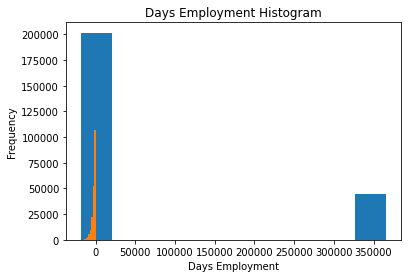

In [9]:
(app_train['DAYS_BIRTH'] / 365).describe().data()

app_train['DAYS_EMPLOYED'].describe().data()

app_train['DAYS_EMPLOYED'].data().plot.hist(title='Days Employment Histogram')
plt.xlabel('Days Employment')

anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean().data()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean().data()))
print('There are %d anomalous days of employment' % anom.shape().data()[0])

# Create an anomalous flag column
days_employed_anom = app_train["DAYS_EMPLOYED"] == 365243
app_train = app_train.add_columns('DAYS_EMPLOYED_ANOM', days_employed_anom)
temp = app_train['DAYS_EMPLOYED'].replace({365243: np.nan})
app_train = app_train.drop('DAYS_EMPLOYED')
app_train = app_train.add_columns('DAYS_EMPLOYED', temp)

app_train["DAYS_EMPLOYED"].data().plot.hist(title='Days Employment Histogram');
plt.xlabel('Days Employment')

days_employed_anom = app_test["DAYS_EMPLOYED"] == 365243
app_test = app_test.add_columns('DAYS_EMPLOYED_ANOM', days_employed_anom)
temp = app_test['DAYS_EMPLOYED'].replace({365243: np.nan})
app_test = app_test.drop('DAYS_EMPLOYED')
app_test = app_test.add_columns('DAYS_EMPLOYED', temp)
print('There are %d anomalies in the test data out of %d entries'
      % (app_test['DAYS_EMPLOYED_ANOM'].sum().data(),
         app_test.shape().data()[0]))

## Correlations


In [10]:
correlations = app_train.corr().data()
top = correlations['TARGET'].sort_values()
# Display correlations
print('Most Positive Correlations:\n', top.tail(15))
print('\nMost Negative Correlations:\n', top.head(15)) 

Most Positive Correlations:
 OCCUPATION_TYPE_Laborers                             0.041558
FLAG_DOCUMENT_3                                      0.043370
FLAG_EMP_PHONE                                       0.045588
REG_CITY_NOT_LIVE_CITY                               0.046057
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049190
DAYS_ID_PUBLISH                                      0.051058
REG_CITY_NOT_WORK_CITY                               0.052260
CODE_GENDER_M                                        0.054916
DAYS_LAST_PHONE_CHANGE                               0.054939
NAME_INCOME_TYPE_Working                             0.057138
REGION_RATING_CLIENT                                 0.058413
REGION_RATING_CLIENT_W_CITY                          0.059987
DAYS_EMPLOYED                                        0.075885
DAYS_BIRTH                                           0.077951
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

## Effect of Age on Repayment 

Text(0.5, 1.0, 'Failure to Repay by Age Group')

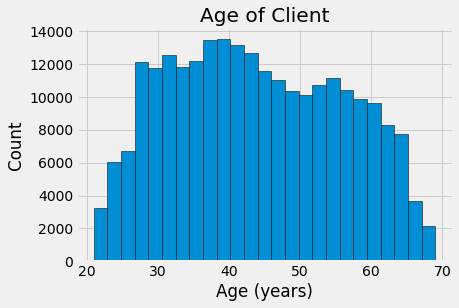

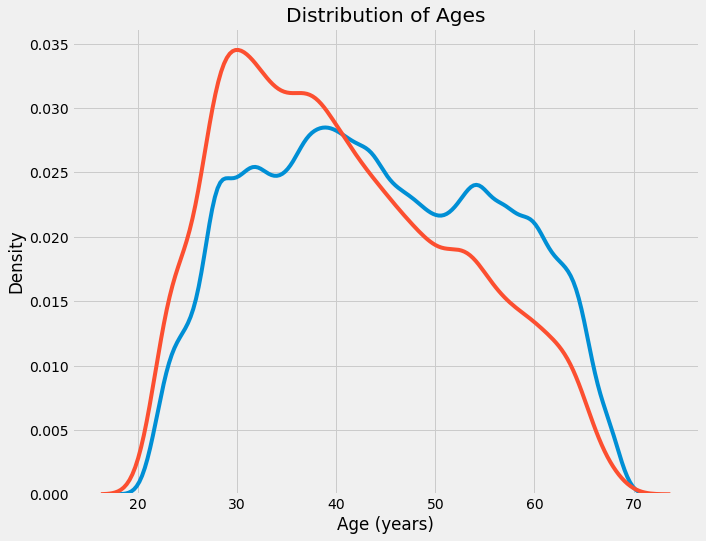

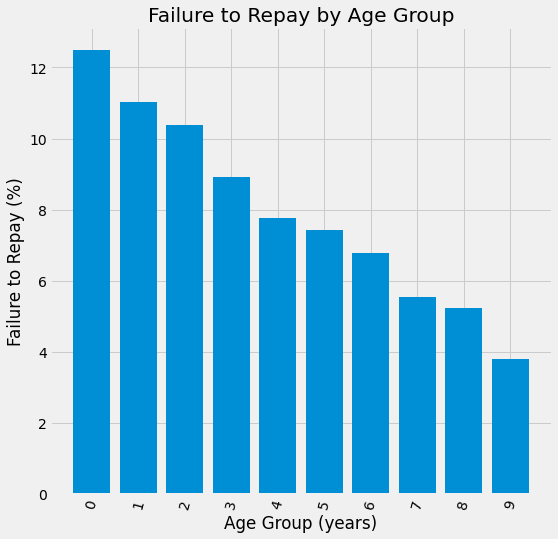

In [11]:
abs_age = app_train['DAYS_BIRTH'].abs()
app_train = app_train.drop('DAYS_BIRTH')
app_train = app_train.add_columns('DAYS_BIRTH', abs_age)
app_train['DAYS_BIRTH'].corr(app_train['TARGET']).data()

# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist((app_train['DAYS_BIRTH'] / 365).data(), edgecolor='k', bins=25)
plt.title('Age of Client')
plt.xlabel('Age (years)')
plt.ylabel('Count')

plt.figure(figsize=(10, 8))
# KDE plot of loans that were repaid on time
sns.kdeplot((app_train[app_train['TARGET'] == 0]['DAYS_BIRTH'] / 365).data(), label='target == 0')
# KDE plot of loans which were not repaid on time
sns.kdeplot((app_train[app_train['TARGET'] == 1]['DAYS_BIRTH'] / 365).data(), label='target == 1')
# Labeling of plot
plt.xlabel('Age (years)')
plt.ylabel('Density')
plt.title('Distribution of Ages')

# Age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
years_birth = age_data['DAYS_BIRTH'] / 365
age_data = age_data.add_columns('YEARS_BIRTH', years_birth)
binned = age_data['YEARS_BIRTH'].binning(20, 70, 11)
binned.setname('YEARS_BINNED')
age_data = age_data.add_columns('YEARS_BINNED', binned)
age_data.head(10).data()

age_groups = age_data.groupby('YEARS_BINNED').mean()
age_groups.data()

plt.figure(figsize=(8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.data().index.astype(str), age_groups.data()['TARGET'] * 100)

# Plot labeling
plt.xticks(rotation=75)
plt.xlabel('Age Group (years)')
plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group')

## Exterior Sources

/Users/bede01/Documents/work/phd-papers/published/ml-workload-optimization/code/collaborative-optimizer/experiment_graph/graph/node.py:1516: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  self.nodes[0].get_materialized_data()[
/Users/bede01/Documents/work/phd-papers/published/ml-workload-optimization/code/collaborative-optimizer/experiment_graph/graph/node.py:1516: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  self.nodes[0].get_materialized_data()[
/Users/bede01/Documents/work/phd-papers/published/ml-workload-optimization/code/collaborative-optimizer/experiment_graph/graph/node.py:1516: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  self.nodes[0].get_materialized_data()[
/Users/bede01/Documents/work/phd-papers/published/ml-workload-optimization/code/collaborative-optimizer/experiment_graph/graph/node.py:1516: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  self.no

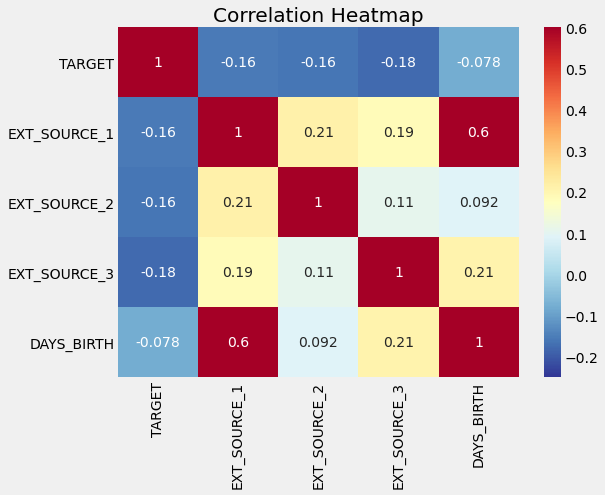

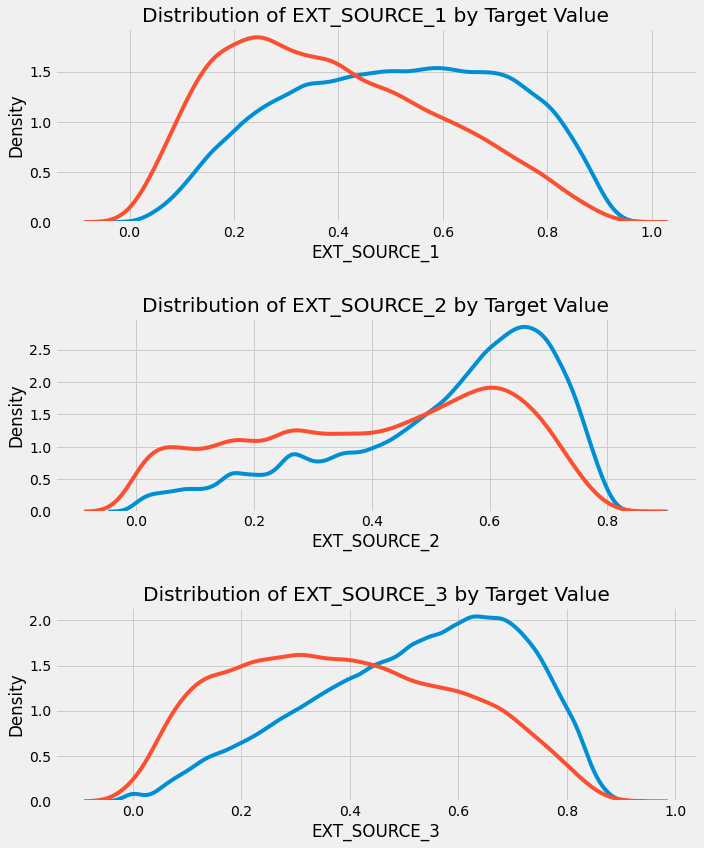

In [12]:
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr().data()

plt.figure(figsize=(8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap=plt.cm.RdYlBu_r, vmin=-0.25, annot=True, vmax=0.6)
plt.title('Correlation Heatmap')

plt.figure(figsize=(10, 12))

# iterate through the sources
for i, column in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    source_data = app_train[[column, 'TARGET']][app_train['TARGET'] == 0]
    sns.kdeplot(source_data[app_train[column].notna()][column].data(), label='target == 0')
    # plot loans that were not repaid
    source_data = app_train[[column, 'TARGET']][app_train['TARGET'] == 1]
    sns.kdeplot(source_data[app_train[column].notna()][column].data(), label='target == 1')

    # Label the plots
    plt.title('Distribution of %s by Target Value' % column)
    plt.xlabel('%s' % column)
    plt.ylabel('Density')

plt.tight_layout(h_pad=2.5)

## Pairs Plot

/Users/bede01/Library/Python/3.9/lib/python/site-packages/seaborn/axisgrid.py:1152: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))
/Users/bede01/Library/Python/3.9/lib/python/site-packages/seaborn/distributions.py:1135: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
/Users/bede01/Library/Python/3.9/lib/python/site-packages/seaborn/distributions.py:1135: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
/Users/bede01/Library/Python/3.9/lib/python/site-packages/seaborn/distributions.py:1135: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
/Users/bede01/Library/Python/3.9/lib/python/site-packages/seaborn/distributions.py:1135: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
/Users/bede01/Library/Python/3.9/lib/python/site-packages/sea

Text(0.5, 1.05, 'Ext Source and Age Features Pairs Plot')

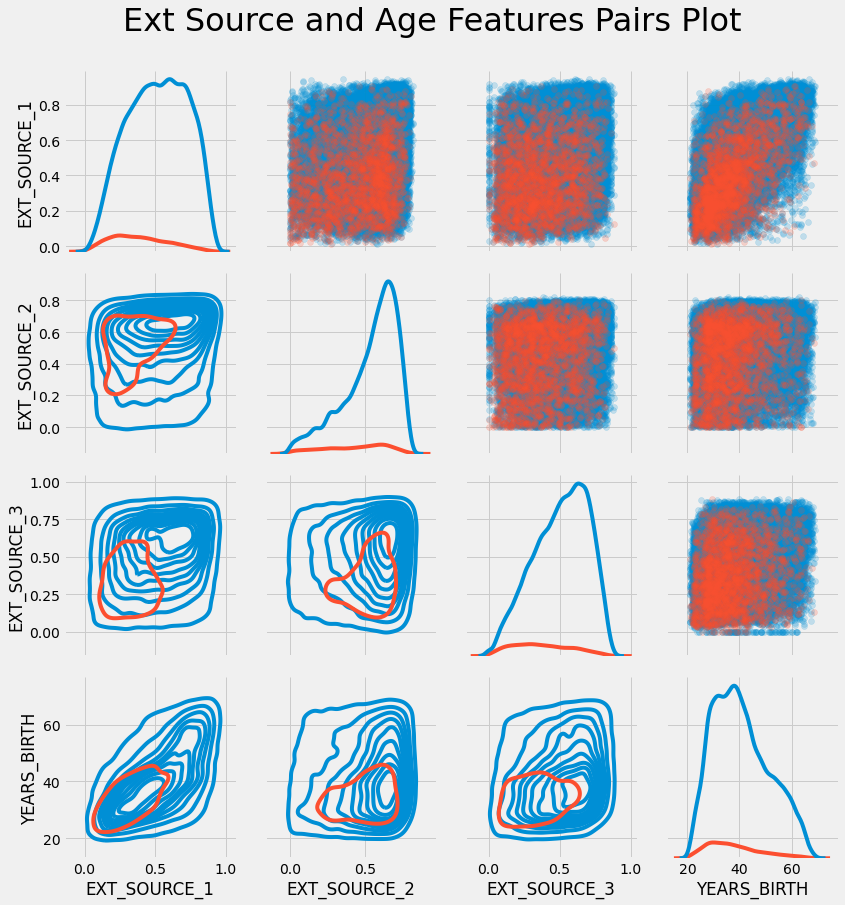

In [13]:
# Copy the data for plotting
plot_data = ext_data.drop('DAYS_BIRTH')

# Add in the age of the client in years
plot_data = plot_data.add_columns('YEARS_BIRTH', age_data['YEARS_BIRTH'])
# Drop na values and limit to first 100000 rows
plot_data = plot_data.head(100000).dropna()

# Create the pair grid object
grid = sns.PairGrid(data=plot_data.data(), size=3, diag_sharey=False,
                    hue='TARGET',
                    vars=[x for x in list(plot_data.data().columns) if x != 'TARGET'])

# Upper is a scatter plot
grid.map_upper(plt.scatter, alpha=0.2)

# Diagonal is a histogram
grid.map_diag(sns.kdeplot)

# Bottom is density plot
grid.map_lower(sns.kdeplot, cmap=plt.cm.OrRd_r)

plt.suptitle('Ext Source and Age Features Pairs Plot', size=32, y=1.05)

## Feature Engineering

In [14]:
# Make a new dataframe for polynomial features
poly_features = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = app_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# imputer for handling missing values
from experiment_graph.sklearn_helper.preprocessing import Imputer

imputer = Imputer(strategy='median')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns=['TARGET'])

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

from experiment_graph.sklearn_helper.preprocessing import PolynomialFeatures

# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree=3)

# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape().data())

new_names = poly_transformer.get_feature_names(input_features=['EXT_SOURCE_1', 'EXT_SOURCE_2',
                                                               'EXT_SOURCE_3', 'DAYS_BIRTH'])

poly_features = poly_features.set_columns(new_names)

# Add in the target
poly_features = poly_features.add_columns('TARGET', poly_target)

# Find the correlations with the target
poly_corrs = poly_features.corr().data()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10))
print(poly_corrs.tail(5))

poly_features_test = poly_features_test.set_columns(new_names)

# Merge polynomial features into training dataframe
poly_features = poly_features.add_columns('SK_ID_CURR', app_train['SK_ID_CURR'])
app_train_poly = app_train.merge(poly_features, on='SK_ID_CURR', how='left')

# Merge polnomial features into testing dataframe
poly_features_test = poly_features_test.add_columns('SK_ID_CURR', app_test['SK_ID_CURR'])
app_test_poly = app_test.merge(poly_features_test, on='SK_ID_CURR', how='left')

# Align the dataframes
app_train_poly = app_train_poly.align(app_test_poly)
app_test_poly = app_test_poly.align(app_train_poly)

# Print out the new shapes
print('Training data with polynomial features shape: ',
      app_train_poly.shape().data())
print('Testing data with polynomial features shape:  ',
      app_test_poly.shape().data())

Polynomial Features shape:  (246008, 35)
EXT_SOURCE_2 EXT_SOURCE_3                -0.193833
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189780
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH     -0.181185
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176396
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172130
EXT_SOURCE_1 EXT_SOURCE_2                -0.167133
EXT_SOURCE_1 EXT_SOURCE_3                -0.163843
EXT_SOURCE_2                             -0.160490
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.157235
EXT_SOURCE_2 DAYS_BIRTH                  -0.156948
Name: TARGET, dtype: float64
DAYS_BIRTH     -0.077951
DAYS_BIRTH^2   -0.076358
DAYS_BIRTH^3   -0.073950
TARGET          1.000000
1                    NaN
Name: TARGET, dtype: float64
Training data with polynomial features shape:  (246008, 280)
Testing data with polynomial features shape:   (61503, 280)


## Domain Knowledge Features

In [15]:
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

app_train_domain = app_train_domain.add_columns('CREDIT_INCOME_PERCENT',
                                                app_train_domain['AMT_CREDIT'] / app_train_domain[
                                                    'AMT_INCOME_TOTAL'])
app_train_domain = app_train_domain.add_columns('ANNUITY_INCOME_PERCENT',
                                                app_train_domain['AMT_ANNUITY'] / app_train_domain[
                                                    'AMT_INCOME_TOTAL'])
app_train_domain = app_train_domain.add_columns('CREDIT_TERM',
                                                app_train_domain['AMT_ANNUITY'] / app_train_domain[
                                                    'AMT_CREDIT'])
app_train_domain = app_train_domain.add_columns('DAYS_EMPLOYED_PERCENT',
                                                app_train_domain['DAYS_EMPLOYED'] / app_train_domain[
                                                    'DAYS_BIRTH'])

app_test_domain = app_test_domain.add_columns('CREDIT_INCOME_PERCENT',
                                              app_test_domain['AMT_CREDIT'] / app_test_domain[
                                                  'AMT_INCOME_TOTAL'])
app_test_domain = app_test_domain.add_columns('ANNUITY_INCOME_PERCENT',
                                              app_test_domain['AMT_ANNUITY'] / app_test_domain[
                                                  'AMT_INCOME_TOTAL'])
app_test_domain = app_test_domain.add_columns('CREDIT_TERM',
                                              app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT'])
app_test_domain = app_test_domain.add_columns('DAYS_EMPLOYED_PERCENT',
                                              app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH'])

## Baseline

In [16]:
from experiment_graph.sklearn_helper.preprocessing import MinMaxScaler

# Drop the target from the training data
columns = app_train.data().columns
if 'TARGET' in columns:
    train = app_train.drop(columns=['TARGET'])
else:
    train = app_train.copy()

# Feature names
features = list(train.data().columns)

# Copy of the testing data
test = app_test.copy()

# Median imputation of missing values
imputer = Imputer(strategy='median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit on the training data
imputer.fit(train)

# Transform both training and testing data
train = imputer.transform(train)
test = imputer.transform(test)

# Repeat with the scaler
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape().data())
print('Testing data shape: ', test.shape().data())

from experiment_graph.sklearn_helper.linear_model import LogisticRegression

# Make the model with the specified regularization parameter
log_reg = LogisticRegression(C=0.0001)

# Train on the training data
log_reg.fit(train, train_labels)

score = log_reg.score(test,
                      test_labels['TARGET'],
                      score_type='auc').data()
print('Logistic Regression with AUC score: {}'.format(score))

Training data shape:  (246008, 245)
Testing data shape:  (61503, 245)
Logistic Regression with AUC score: {'auc': 0.6166159529933799}


## Improved Model: Random Forest

In [17]:
from experiment_graph.sklearn_helper.ensemble import RandomForestClassifier

# Make the random forest classifier
random_forest = RandomForestClassifier(n_estimators=100, random_state=50, verbose=1, n_jobs=-1)

# Train on the training data
random_forest.fit(train, train_labels)

# Extract feature importance
feature_importances = random_forest.feature_importances(features)

score = random_forest.score(test,
                            test_labels['TARGET'],
                            score_type='auc').data()
print('Random Forest Simple Data with AUC score: {}'.format(score))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   38.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s


Random Forest Simple Data with AUC score: {'auc': 0.5316355468834253}


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished


## Make Predictions using Engineered Features

In [18]:
poly_features_names = list(app_train_poly.data().columns)

# Impute the polynomial features
imputer2 = Imputer(strategy='median')

imputer2.fit(app_train_poly)

app_train_poly = imputer2.transform(app_train_poly)
app_test_poly = imputer2.transform(app_test_poly)

# Scale the polynomial features
scaler = MinMaxScaler(feature_range=(0, 1))

app_train_poly = scaler.fit_transform(app_train_poly)
app_test_poly = scaler.transform(app_test_poly)

random_forest_poly = RandomForestClassifier(n_estimators=100, random_state=50, verbose=1, n_jobs=-1)
random_forest_poly.fit(app_train_poly, train_labels)

score = random_forest_poly.score(app_test_poly,
                                 test_labels['TARGET'],
                                 score_type='auc').data()
print('Random Forest Poly Data with AUC score: {}'.format(score))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   51.4s finished


Random Forest Poly Data with AUC score: {'auc': 0.5274272217668755}


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished


## Testing Domain Features

In [19]:
app_train_domain = app_train_domain.drop(columns='TARGET')

domain_features_names = list(app_train_domain.data().columns)

# Impute the domainnomial features
imputer = Imputer(strategy='median')

domain_features = imputer.fit_transform(app_train_domain)
domain_features_test = imputer.transform(app_test_domain)

# Scale the domainnomial features
scaler = MinMaxScaler(feature_range=(0, 1))

domain_features = scaler.fit_transform(domain_features)
domain_features_test = scaler.transform(domain_features_test)

# Train on the training data
random_forest_domain = RandomForestClassifier(n_estimators=100, random_state=50, verbose=1, n_jobs=-1)
random_forest_domain.fit(domain_features, train_labels)

# Extract feature importances
feature_importances_domain = random_forest_domain.feature_importances(domain_features_names)

score = random_forest_domain.score(domain_features_test,
                                   test_labels['TARGET'],
                                   score_type='auc').data()
print('Random Forest Domain Data with AUC score: {}'.format(score))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   39.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s


Random Forest Domain Data with AUC score: {'auc': 0.5084427092766229}


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished
